In [1]:
import math
import meep as mp
from meep import mpb
import matplotlib.pyplot as plt
import pandas as pd

# 1. Bandstructure for perfect crystal

First, we initialize the crystal structure, using a triangular lattice with airholes of radius 0.3a. The background material is Indium Aluminum Arsenide, with refractive index 3.23 (is this correct?).

In [106]:
k_points = [
    mp.Vector3(y=0.25),               # Gamma
              mp.Vector3(y=0.5),          # M
              mp.Vector3(-1/3, 1/3),  # K
            #   mp.Vector3(0.3, 0.3)
              ]               # Gamma
k_points = mp.interpolate(100, k_points)

geometry_lattice = mp.Lattice(size=mp.Vector3(1, 1),
                                 basis1=mp.Vector3(math.sqrt(3) / 2, 0.5),
                                 basis2=mp.Vector3(math.sqrt(3) / 2, -0.5))

# Initialize the holes. 
geometry = [mp.Cylinder(0.4, material=mp.air)]

default_material=mp.Medium(epsilon=10.4329)
resolution = 16
num_bands = 18

ms = mpb.ModeSolver(num_bands=num_bands,
                    k_points=k_points,
                    geometry=geometry,
                    geometry_lattice=geometry_lattice,
                    resolution=resolution,
                    default_material=default_material)

Next, we run simulations for TE waves within the 2D structure. 

In [107]:
import io
import contextlib

f = io.StringIO()
with contextlib.redirect_stdout(f):
    ms.run_te(mpb.display_group_velocities)

output = f.getvalue().splitlines()
tefreq_output = [line for line in output if line.startswith("tefreqs")]
vg_str = [line for line in output if line.startswith("tevelocity") or line.startswith("velocity")]


In [108]:
def parse_vector3(vector_str):
    """Parse a Vector3 string into its components."""
    # Strip the Vector3<> part and split by comma
    components = vector_str.replace('Vector3<', '').replace('>', '').split(', ')
    # Convert components to float

    return mp.Vector3(*(float(c.strip()) for c in components))

def process_line(line):
    """Process a single line of the file."""
    parts = line.split(', ')
    k_index = int(parts[1].strip())
    vectors = ", ".join(parts[2:]).split(">, ")
    parsed_vectors = [parse_vector3(vector) for vector in vectors]
    return k_index, parsed_vectors

vector_data = [
    process_line(line) for line in vg_str
]

print(vector_data[0])  # List of tuples (k_index, [group velocity for each band at that k-index])

(1, [Vector3<0.239799879793614, -0.4146310351589061, 0.0>, Vector3<-0.15167759774810846, 0.26343052599366534, 0.0>, Vector3<-0.08424102428672554, 0.14937177595698856, 0.0>, Vector3<-0.07269711490619482, 0.11004380367960827, 0.0>, Vector3<0.07789372307441982, -0.10519451628862013, 0.0>, Vector3<0.11244035277337483, -0.22077688920916091, 0.0>, Vector3<0.09221204569646094, -0.15297833593479965, 0.0>, Vector3<-0.03608269720974601, 0.021739556769195447, 0.0>, Vector3<-0.014301891977779625, 0.05671808491528772, 0.0>, Vector3<0.11102876607916741, -0.14667859765556635, 0.0>, Vector3<-0.048376644361413104, 0.10499292242187748, 0.0>, Vector3<-0.004913255031528247, -0.04638252459312204, 0.0>, Vector3<0.0552473994236606, -0.12437990348467252, 0.0>, Vector3<-0.11531863879746262, 0.22318481745162605, 0.0>, Vector3<-0.05665545408000952, 0.11748525093948262, 0.0>, Vector3<0.0639853118889453, -0.024735120674742563, 0.0>, Vector3<0.03046155515872035, -0.15235008719510712, 0.0>, Vector3<0.013386275571029

Finally, we graph the output. 

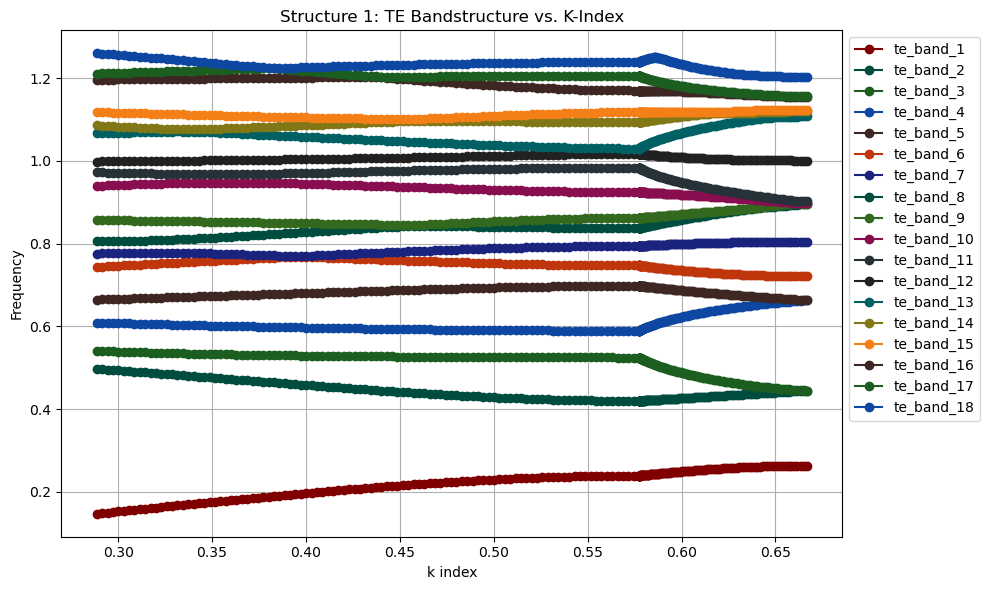

In [109]:
df = pd.read_csv(io.StringIO("\n".join(tefreq_output)))
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

plt.figure(figsize=(10, 6))


te_bands = df.filter(like='te_band')
# Define a list of distinct, high-contrast colors
colors = ['#800000', '#004D40', '#1B5E20', '#0D47A1', '#3E2723', '#BF360C', '#1A237E', '#004D40', '#33691E', '#880E4F', '#263238', '#212121', '#006064', '#827717', '#F57F17', '#3E2723', '#1B5E20', '#0D47A1', '#004D40', '#263238', '#212121', '#424242']

# Ensure there are enough colors for the bands, repeat the color list if necessary
if len(te_bands.columns) > len(colors):
    colors = colors * (len(te_bands.columns) // len(colors) + 1)

k_indices = df['kmag/2pi']
# k_indices = df['k_index']

for i, column in enumerate(te_bands.columns):
    plt.plot(k_indices, te_bands[column], label=column, marker='o', linestyle='-', color=colors[i])

plt.xlabel('k index')
plt.ylabel('Frequency')
plt.title('Structure 1: TE Bandstructure vs. K-Index')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

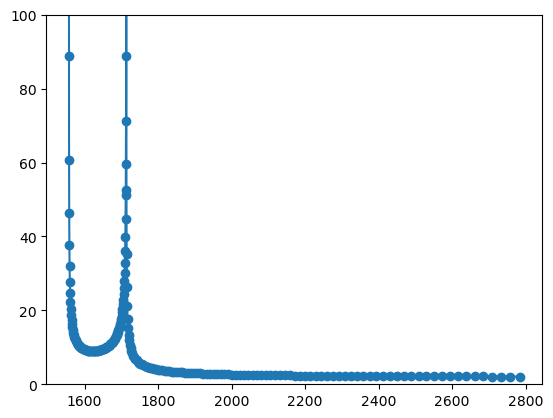

In [110]:
band_velocities = [vector_data[k][1][0] for k in range(0, len(vector_data))]
band_group_indices = [1 / (velocity.norm()+0.00000001) for velocity in band_velocities]

# Convert frequencies to wavelengths
band_frequencies = te_bands['te_band_1']
a = 410
band_wavelengths = a / band_frequencies
band_wavelengths = band_wavelengths.values # Convert from a Pandas series to a numpy array for easier handling. 

plt.figure()
ax = plt.gca()
ax.set_ylim([0, 100])
plt.plot(band_wavelengths, band_group_indices, marker='o')